In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import cv2
import os

In [43]:
# ------------------------------
# ----- preparing the data -----
# ------------------------------

data_path = "data/chest_xray"

# for dirname, _, filenames in os.walk(data_path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [44]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [45]:
train = get_training_data(f"{data_path}/train")
test = get_training_data(f"{data_path}/test")
val = get_training_data(f"{data_path}/val")

/var/folders/08/zzvsnmmd5j1f3xb70b367bk40000gn/T/ipykernel_61890/939447601.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<AxesSubplot: xlabel='count'>

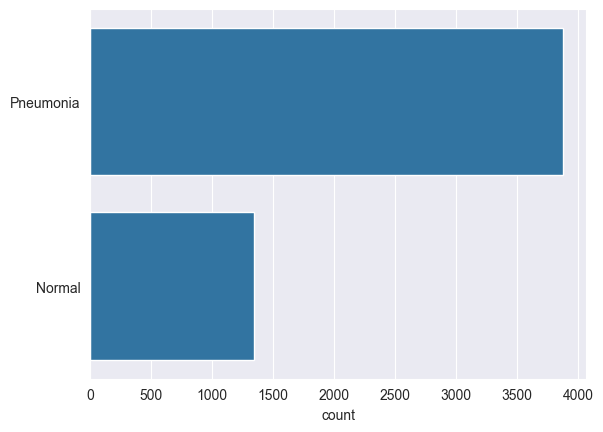

In [46]:
# ------------------------------
# ----- data visualisation -----
# ------------------------------

l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

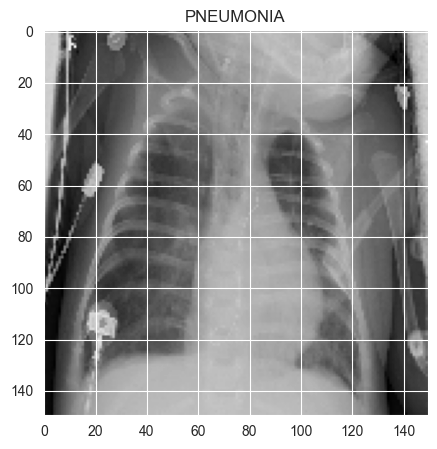

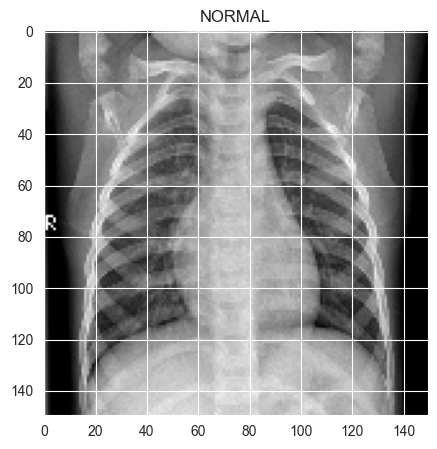

In [47]:
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [48]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [49]:
# ------------------------------
# ----- data normalisation -----
# ------------------------------
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# -------------------------
# ----- data resizing -----
# -------------------------
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [50]:
# -----------------------------
# ----- data augmentation -----
# -----------------------------
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [51]:
# ------------------------------
# ----- creating the model -----
# ------------------------------
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [55]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12,
                    validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 10s 58ms/step - loss: 0.0953 - accuracy: 0.9701 - val_loss: 4.6591 - val_accuracy: 0.5625 - lr: 9.0000e-05
Epoch 2/12
163/163 [==============================] - 9s 53ms/step - loss: 0.0877 - accuracy: 0.9689 - val_loss: 2.6263 - val_accuracy: 0.5000 - lr: 9.0000e-05
Epoch 3/12
163/163 [==============================] - 9s 55ms/step - loss: 0.0952 - accuracy: 0.9666 - val_loss: 0.6324 - val_accuracy: 0.7500 - lr: 9.0000e-05
Epoch 4/12
163/163 [==============================] - 9s 54ms/step - loss: 0.0987 - accuracy: 0.9651 - val_loss: 0.7833 - val_accuracy: 0.6250 - lr: 9.0000e-05
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9701
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
163/163 [==============================] - 9s 53ms/step - loss: 0.1026 - accuracy: 0.9701 - val_loss: 3.7257 - val_accuracy: 0.5625 - lr: 9.0000e-05
Epoch 6/12
163/163 [==================

In [56]:
print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")

20/20 [==============================] - 0s 16ms/step - loss: 0.3358 - accuracy: 0.9151
Loss of the model is -  0.3357767164707184
20/20 [==============================] - 0s 15ms/step - loss: 0.3358 - accuracy: 0.9151
Accuracy of the model is -  91.50640964508057 %


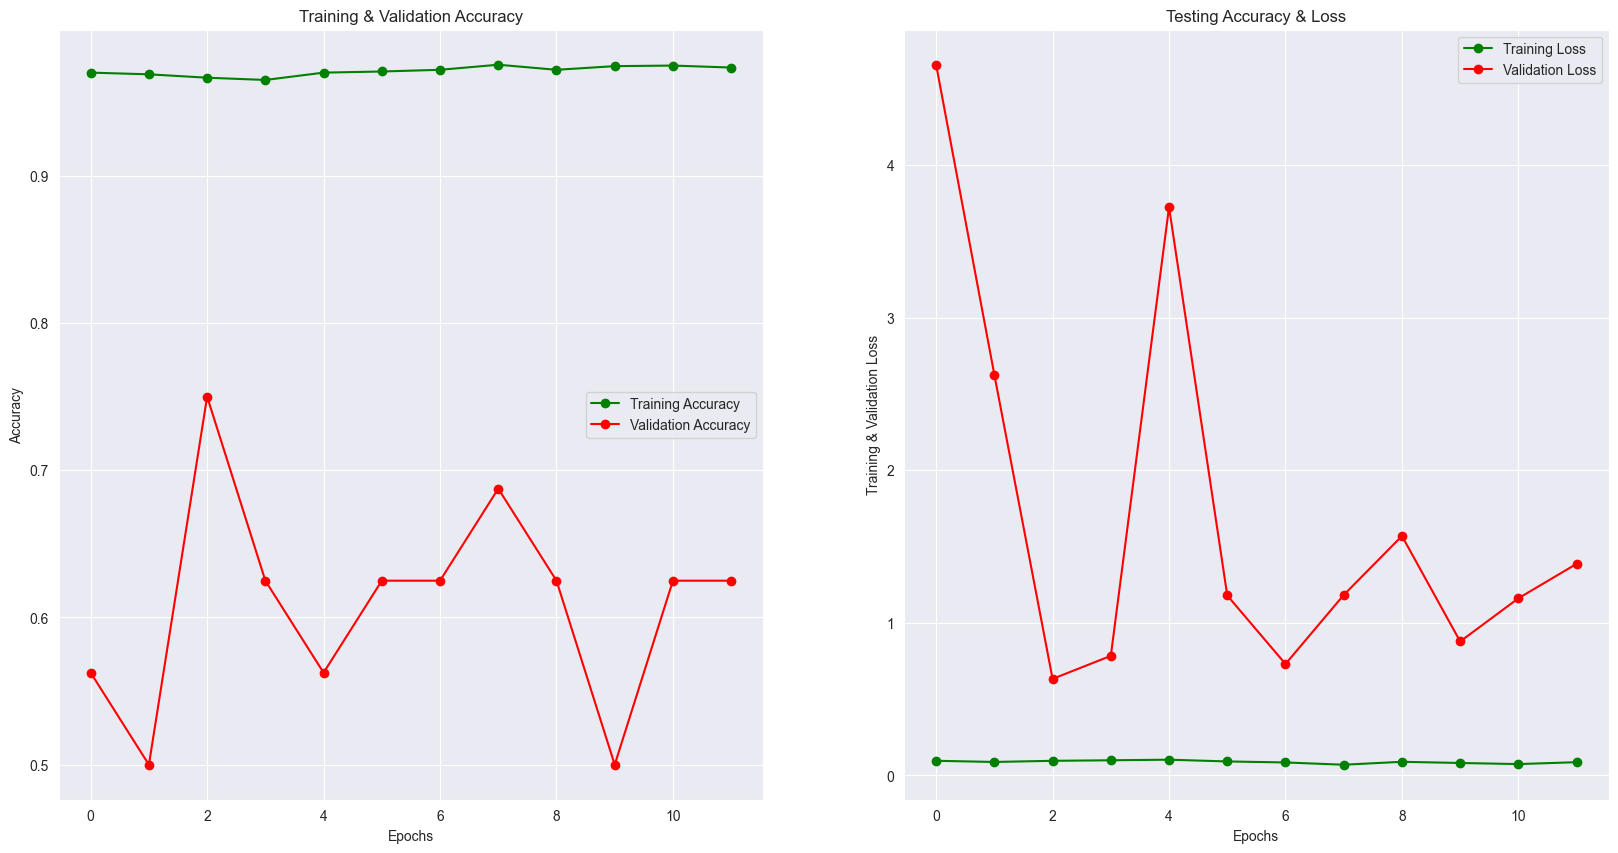

In [57]:
# -----------------------------------------
# ----- model analysis after training -----
# -----------------------------------------

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [69]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

20/20 [==============================] - 0s 22ms/step


array([5.10745303e-05, 1.79077251e-08, 5.36907325e-03, 3.13183554e-14,
       5.11419415e-01, 8.20648819e-02, 3.56780171e-01, 1.23451084e-01,
       3.51119906e-17, 1.28510538e-12, 4.39419225e-02, 1.26009243e-13,
       1.70008335e-02, 1.03755899e-01, 2.00955872e-03], dtype=float32)

In [70]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [72]:
cm = confusion_matrix(y_test, predictions)
cm

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [71]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])


NameError: name 'cm' is not defined

In [74]:
plt.figure(figsize=(10, 10))
# sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels,
#             yticklabels=labels)
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<Figure size 1000x1000 with 0 Axes>

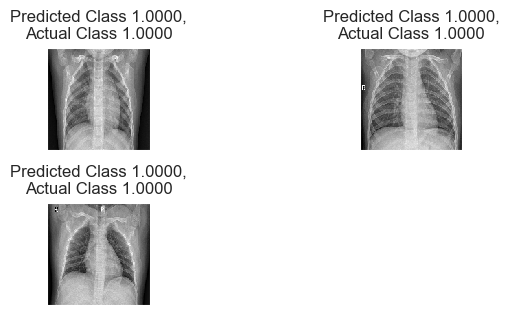

In [80]:
# ------------------------------------------
# ----- some correct predicted classes -----
# ------------------------------------------
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {:.4f},\nActual Class {:.4f}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


/var/folders/08/zzvsnmmd5j1f3xb70b367bk40000gn/T/ipykernel_61890/2745237251.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i + 1)


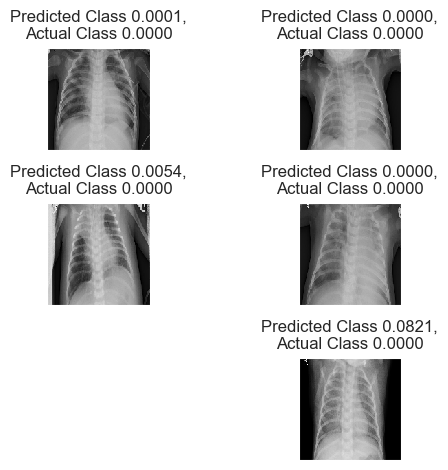

In [81]:
# --------------------------------------------
# ----- some incorrect predicted classes -----
# --------------------------------------------
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {:.4f},\nActual Class {:.4f}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1